# Part II: Model-based Regularization

Now that we know the main caveats of solving inverse problems, it's time to find out how to tackle them! The keyword here will be **regularization**. A regularization method is usually adapted to the noise level $\delta$ with a regularization parameter $\lambda > 0$ and has two essential properties:
* The regularization method is **continuous** (i.e., stable) for all choices of $\lambda$.
* As the noise level tends to zero, the regularization method **converges pointwise to a generalized inverse** (e.g., the operator that maps a noisy measurement to the minimum norm solution).

A popular class of regularization methods can be formulated as a variational problem, where the reconstruction $x^*$ of a noisy measurement $y^{\delta}$ is obtained as the solution of
$$ x^* = \operatorname*{arg\ min}_x \frac{1}{2}\|Ax-y^{\delta}\|^2_2 + \lambda J(x), $$
where the functional $J$ is called the regularization functional and penalizes unwanted behaviour of $x$. In this part of the tutorial, we will see what typical examples of $J$ look like and get an idea of how the minimizer of the above problem can be found. For a stochastical interpretation of the variational formulation stay tuned for the last part of this tutorial.

In [1]:
import skimage as ski
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display
import operators
import optimizers
import numpy as np

phantom = ski.transform.resize(ski.data.shepp_logan_phantom(), (128,128))
theta = np.linspace(0,180, endpoint=False, num=128)
R = operators.Radon(theta=theta)

y = R(phantom) + np.random.normal(scale=0.01,size=(128,128))
x = R.inv(y)


## Tikhonov Regularization

The first regularization functional we consider is $J(x) = \frac{1}{2}\|x\|^2_2 $. An easy interpretation of this would be that **penalizing reconstructions with a large norm prevents the error from exploding** (compare Task 1.4). The resulting variational problem then reads
$$ x^* = \operatorname*{arg\ min}_x \frac{1}{2}\|Ax-y^{\delta}\|^2_2 + \frac{\lambda}{2} \|x\|^2_2.$$

Analytically, the solution of the above problem can be computed as 
$$ x^* = (A^*A + \lambda \operatorname{Id})^{-1} A^*y^\delta,$$
where $A^*$ denotes the adjoint of $A$ and $\operatorname{Id}$ denotes the identity operator. In this form, the method is also known as Tikhonov regularization.

Since we cannot easily access $(A^*A + \lambda \operatorname{Id})^{-1}$, we can perform a simple gradient descent with stepsize $t > 0$ of the form
$$ x \leftarrow x - t \cdot (A^*Ax + \lambda x - A^*y^\delta )$$

### &#128221; <span style="color:darkorange"> Task 2.1 </span>
#### Complete the following algorithm that performs gradient descent to solve the Tikhonov regularization problem.

Iteration: 1
Energy: 64.24212997353509
Iteration: 2
Energy: 51.50392786290798
Iteration: 3
Energy: 42.7060857761162
Iteration: 4
Energy: 36.60378790166778
Iteration: 5
Energy: 32.35966020708487
Iteration: 6
Energy: 29.399741548149134
Iteration: 7
Energy: 27.32968205460204
Iteration: 8
Energy: 25.87788092091202
Iteration: 9
Energy: 24.85681117467879
Iteration: 10
Energy: 24.13666070904979
Iteration: 11
Energy: 23.627330847775067


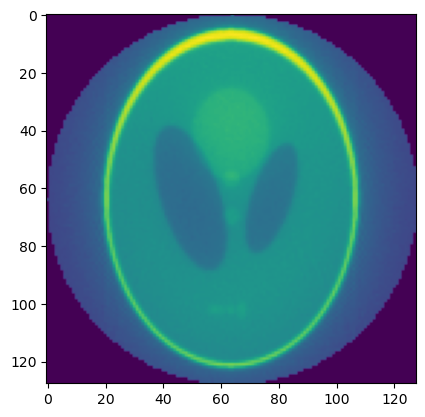

In [34]:

class gradient_descent(optimizers.optimizer):
    def __init__(self, A, x, y, t=0.1, lamda=1.0, **kwargs):
        super().__init__(**kwargs)
        self.A = A
        self.x = x
        self.y = y
        self.t = t
        self.lamda = lamda
        def energy_fun(x):
            return 0.5* np.linalg.norm(A(x)-y) + lamda*np.linalg.norm(x, ord=1)
        self.energy_fun=energy_fun

    def step(self,):
        grad = self.A.adjoint(self.A(self.x)) + self.lamda*self.x - self.A.adjoint(self.y)
        self.x = self.x - self.t*grad



gd = gradient_descent(R, x, y, lamda=2.5, t=0.1)

gd.solve()

plt.imshow(gd.x)



## Sparsity Promoting Regularization
Another demand on the regularization method could be that the obtained **reconstructions should simple in a certain sense**. This means that they should be composed of only a few building blocks. 

The two ingredients we will need to enforce this are
* an operator $D$ which decomposes $x$ into building blocks, for example a wavelet decomposition
* the $\|\cdot\|_1$-norm which promotes sparsity, i.e., penalizes non-zero entries of $Dx$.

The resulting variational problem then reads
$$ x^* = \operatorname*{arg\ min}_x \frac{1}{2}\|Ax-y^{\delta}\|^2_2 + \lambda \|Dx\|_1.$$

Since the regularization functional is in general not differentiable, we will use the so-called proximal gradient descent algorithm. The proximal map of a functional $J$ with parameter $\lambda$ is defined as
$$ \operatorname{prox}_{\lambda J}(x) = \operatorname*{arg\ min}_z \frac{1}{2}\|x-z\|_2^2 + \lambda J(z).$$

Fortunately, the proximal map of the functionals we consider now is easy to compute with the help of the soft-shrinkage function, which is in fact the proximal map of the $\|\cdot\|_1$-norm. For different choices of $\lambda$ it looks as follows:

In [2]:
v = np.linspace(-10,10, num=100)
def plot_soft(lamda):
    w = optimizers.soft_shrinkage(v, lamda)
    plt.plot(v,w)
    plt.ylim([-10,10])
    plt.title('$prox_{\lambda \|\cdot\|_1}$')
    
slider = widgets.FloatSlider(min = 0, max = 10, step = 0.5, value = 1, continuous_update = True)
interactive_plot = interactive(plot_soft, lamda = slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=1.0, description='lamda', max=10.0, step=0.5), Output()), _dom_classes…

### &#128221; <span style="color:darkorange"> Task 2.2 </span>
#### Try out sparsity promoting regularization for the following choices of $D$ and describe how the reconstructions change depending on $D$:
* Identity
* Haar Wavelet
* Daubechies4 Wavelet

Iteration: 1
Energy: inf
Iteration: 2
Energy: inf
Iteration: 3
Energy: inf
Iteration: 4
Energy: inf
Iteration: 5
Energy: inf
Iteration: 6
Energy: inf
Iteration: 7
Energy: inf
Iteration: 8
Energy: inf
Iteration: 9
Energy: inf
Iteration: 10
Energy: inf
Iteration: 11
Energy: inf


c:\Users\kugerlor\AppData\Local\miniconda3\envs\incubator\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Iteration: 1
Energy: 26.915866143829955
Iteration: 2
Energy: 26.317607354410594
Iteration: 3
Energy: 25.78379360792804
Iteration: 4
Energy: 25.306995953587318
Iteration: 5
Energy: 24.88890449295557
Iteration: 6
Energy: 24.536801726408108
Iteration: 7
Energy: 24.26714383621568
Iteration: 8
Energy: 24.03111119689514
Iteration: 9
Energy: 23.82556959716462
Iteration: 10
Energy: 23.652253085078
Iteration: 11
Energy: 23.50310786564325
Iteration: 1
Energy: 38.83390569214885
Iteration: 2
Energy: 38.064241386893535
Iteration: 3
Energy: 37.39265698528762
Iteration: 4
Energy: 36.80134903798792
Iteration: 5
Energy: 36.301526828987726
Iteration: 6
Energy: 35.87816664531117
Iteration: 7
Energy: 35.5150073245765
Iteration: 8
Energy: 35.208650395433274
Iteration: 9
Energy: 34.9335106149474
Iteration: 10
Energy: 34.687910794629246
Iteration: 11
Energy: 34.46233898181966


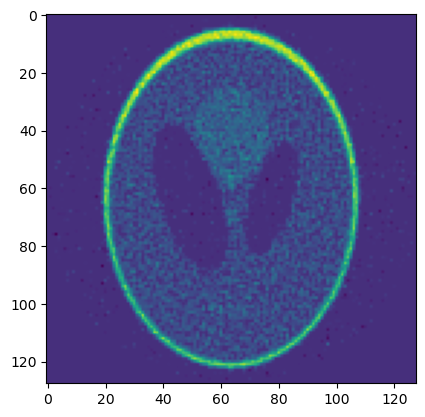

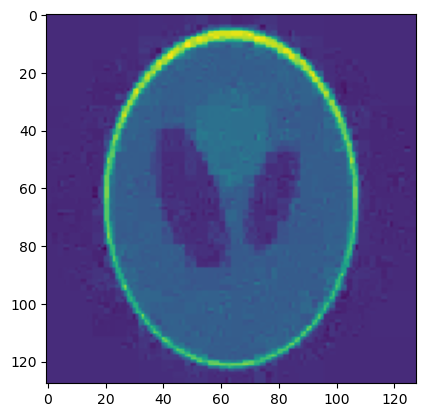

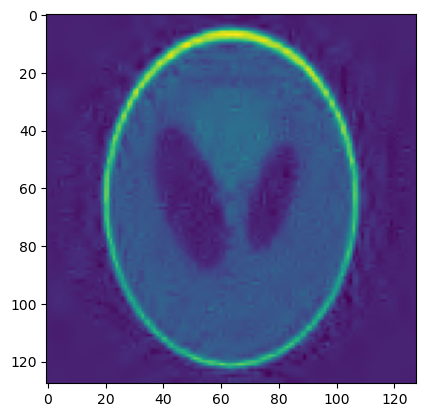

In [3]:
import pywt

opti1 = optimizers.ista_L1(R, x, y, lamda=1, t = 0.01)
opti1.solve()
plt.figure()
plt.imshow(opti1.x)

opti2 = optimizers.ista_wavelets(R, x, y, wave= pywt.Wavelet('haar'), lamda=1, t = 0.01)
opti2.solve()
plt.figure()
plt.imshow(opti2.x)

opti3 = optimizers.ista_wavelets(R, x, y, wave= pywt.Wavelet('db4'), lamda=1, t = 0.01)
opti3.solve()
plt.figure()
plt.imshow(opti3.x)

## Total Variation Regularization